# How much effort would it take to jump between West Hall and East Hall?

Mellie Zito and Annie Tor

ModSim Section 1, Group 13

In [25]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

## Model

### Set up

In [26]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
degree = UNITS.degree;

In [27]:
params = Params(x = 0 * m, #original x position
                y = 12.2 * m, #original y position (12.2 is the height of the edge of West Hall)
                g = 9.8 * m/s**2, #acceleration due to gravity
                mass = 70 * kg, #average mass of a human adult
                diameter = 0.711 * m, #average diameter of a balled-up human (based off Annie)
                rho = 1.2 * kg/m**3, #density of air 
                C_d = 0.47, #drag coefficient of a sphere
                angle = 45 * degree, #initial launch angle
                velocity = 40 * m / s, #initial launch velocity
                t_end = 20 * s) #point at which to end the simulation

,values
x,0 meter
y,12.2 meter
g,9.8 meter / second ** 2
mass,70 kilogram
diameter,0.711 meter
rho,1.2 kilogram / meter ** 3
C_d,0.47
angle,45 degree
velocity,40.0 meter / second
t_end,20 second


In [28]:
def make_system(params):
    """Make a system object.
    
    params: Params object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(params)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    return System(params, init=init, area=area)

In [29]:
def drag_force(V, system):
    """Computes drag force in the opposite direction of `V`.
    
    V: velocity
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    unpack(system)
    mag = -rho * V.mag**2 * C_d * area / 2
    direction = V.hat()
    f_drag = mag * direction
    return f_drag

In [30]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    V = Vector(vx, vy)    
    a_drag = drag_force(V, system) / mass
    a_grav = Vector(0, -g)
    
    a = a_grav + a_drag
    
    return vx, vy, a.x, a.y

In [31]:
def event_func(state, t, system):
    """Stop when the y coordinate is 0.
    
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    x, y, vx, vy = state
    return y 

### Maximum Range and Height based on Angle

In [60]:
system = make_system(params)

def event_func1(state, t, system):
    """Stop when the x coordinate is 94.5m.
    
    state: State object
    t: time
    system: System object
    
    returns: x coordinate - 94.5m
    """
    x, y, vx, vy = state
    return x - 18 * m

event_func(system.init, 0, system)

def height_func(angle, params):  
    """Computes range for a given launch angle.
    
    angle: launch angle in degrees
    params: Params object
    
    returns: distance in meters
    """
    params = Params(params, angle=angle)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func1)
    y_dist = get_last_value(results.y) * m
    return y_dist

def range_func(angle, params):  
    """Computes range for a given launch angle.
    
    angle: launch angle in degrees
    params: Params object
    
    returns: distance in meters
    """
    params = Params(params, angle=angle)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func)
    x_dist = get_last_value(results.x) * m
    return x_dist

In [61]:
height_func(45 * degree, params)

<Quantity(28.162062674912352, 'meter')>

In [73]:
angles = linspace(0, 68, 30)
sweep_range = SweepSeries()
sweep_height = SweepSeries()

for angle in angles:
    x_dist = range_func(angle, params)
    #print(angle, y_dist)
    sweep_range[angle] = x_dist
    
for angle in angles:
    y_dist = height_func(angle, params)
    #print(angle, y_dist)
    sweep_height[angle] = y_dist

Saving figure to file figs/OlinLaunch-fig01.pdf


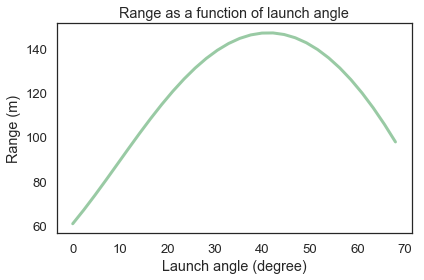

In [74]:
plot(sweep_range, color = 'C2')
decorate(xlabel='Launch angle (degree)',
         ylabel='Range (m)',
         title='Range as a function of launch angle',
         legend=False)

savefig('figs/OlinLaunch-fig01.pdf')

Saving figure to file figs/OlinLaunch-fig02.pdf


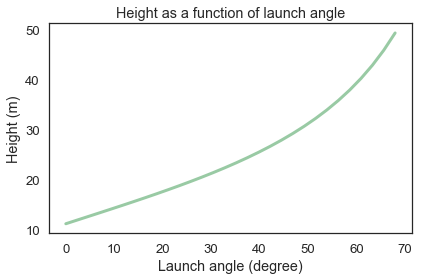

In [75]:
plot(sweep_height, color = 'C2')
decorate(xlabel='Launch angle (degree)',
         ylabel='Height (m)',
         title='Height as a function of launch angle',
         legend=False)

savefig('figs/OlinLaunch-fig02.pdf')

In [66]:
results = max_bounded(range_func, [0, 90], params)

,values
fun,146.98035766503887 meter
status,0
success,True
message,Solution found.
x,41.2316
nfev,9


With initial velocity 40 m/s and an optimal launch angle, the person soars over the wall. Next we figure out the minimum velocity needed.

### Finding the minimum velocity

In [98]:
params = Params(x = 0 * m, #original x position
                y = 12.2 * m, #original y position (12.2 is the height of the edge of West Hall)
                g = 9.8 * m/s**2, #acceleration due to gravity
                mass = 70 * kg, #average mass of a human adult
                diameter = 0.711 * m, #average diameter of a balled-up human (based off Annie)
                rho = 1.2 * kg/m**3, #density of air 
                C_d = 0.47, #drag coefficient of a sphere
                angle = results.x * degree, #initial launch angle
                velocity = 40 * m / s, #initial launch velocity
                t_end = 20 * s) #point at which to end the simulation

,values
x,0 meter
y,12.2 meter
g,9.8 meter / second ** 2
mass,70 kilogram
diameter,0.711 meter
rho,1.2 kilogram / meter ** 3
C_d,0.47
angle,0.000000 0.000000 0.000061 0.001732 ...
velocity,40.0 meter / second
t_end,20 second


In [95]:
def error_func2(v, params):
    params.velocity = v * m/s
    system = make_system(params)
    results = max_bounded(height_func, [0, 90], params)
    height = results.fun
    return height - 16 * m

Test your error function before you call `fsolve`.

In [96]:
error_func2(40, params)

<Quantity(67.5291267675232, 'meter')>

Then use `fsolve` to find the answer to the problem, the minimum velocity that gets the ball out of the park.

In [97]:
min_v = fsolve(error_func2, 40, params)
min_v[0]

14.932360306854207

And just to check, run `error_func` with the value you found.

In [80]:
error_func2(min_v[0], params)

<Quantity(-5.165645688975928e-12, 'meter')>

### Graphing x and y

In [87]:
params = Params(x = 0 * m, #original x position
                y = 12.2 * m, #original y position (12.2 is the height of the edge of West Hall)
                g = 9.8 * m/s**2, #acceleration due to gravity
                mass = 70 * kg, #average mass of a human adult
                diameter = 0.711 * m, #average diameter of a balled-up human (based off Annie)
                rho = 1.2 * kg/m**3, #density of air 
                C_d = 0.47, #drag coefficient of a sphere
                angle = 45 * degree, #initial launch angle
                velocity = min_v[0] * m / s, #initial launch velocity
                t_end = 20 * s) #point at which to end the simulation

,values
x,0 meter
y,12.2 meter
g,9.8 meter / second ** 2
mass,70 kilogram
diameter,0.711 meter
rho,1.2 kilogram / meter ** 3
C_d,0.47
angle,45 degree
velocity,14.932360306854207 meter / second
t_end,20 second


In [99]:
def make_system(params):
    """Make a system object.
    
    params: Params object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(params)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    return System(params, init=init, area=area)

In [89]:
def drag_force(V, system):
    """Computes drag force in the opposite direction of `V`.
    
    V: velocity
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    unpack(system)
    mag = -rho * V.mag**2 * C_d * area / 2
    direction = V.hat()
    f_drag = mag * direction
    return f_drag

In [90]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    V = Vector(vx, vy)    
    a_drag = drag_force(V, system) / mass
    a_grav = Vector(0, -g)
    
    a = a_grav + a_drag
    
    return vx, vy, a.x, a.y

In [91]:
def event_func2(state, t, system):
    """Stop when the y coordinate is 0.
    
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    x, y, vx, vy = state
    return y 

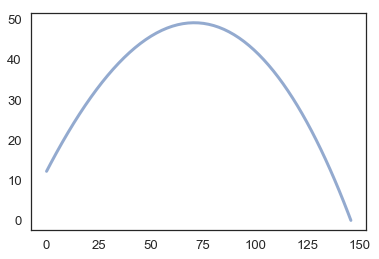

In [93]:
results, details = run_ode_solver(system, slope_func, events=event_func2, max_step=0.1)
plot(results.x, results.y)

In [48]:
results

,x,y,vx,vy
0.000000,0.000000,12.200000,28.284271,28.284271
0.000061,0.001732,12.201732,28.284160,28.283560
0.000674,0.019051,12.219049,28.283052,28.276452
0.006797,0.192206,12.391980,28.271984,28.205388
0.068031,1.920051,14.097406,28.162412,27.497141
0.680372,18.851888,28.813738,27.169184,20.630360
4.685106,118.449683,30.087967,22.817003,-18.765740
5.930529,145.986518,0.000000,21.370416,-29.379896
